# Machine-Learning

- 各手法の学習やまとめ

---

## Useful Links

### optuna
- https://qiita.com/studio_haneya/items/2dc3ba9d7cafa36ddffa
- https://qiita.com/koshian2/items/1c0f781d244a6046b83e
- https://qiita.com/hideki/items/c09242639fd74abe73a0
- https://tech.preferred.jp/ja/blog/hyperparameter-tuning-with-optuna-integration-lightgbm-tuner/
- https://qiita.com/tjmnmn/items/dee7f7e61328e6dd93f7

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [3]:
import xgboost as xgb
import lightgbm as lgb

In [4]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [5]:
import umap
import optuna

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

- TestData

In [21]:
boston = load_boston()
X, y = boston["data"], boston["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [22]:
def objective(trial):
    svr_c = trial.suggest_loguniform('svr_c', 1e0, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-1, 1e1)
    svr = SVR(C=svr_c, epsilon=epsilon)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_val)
    return mean_squared_error(y_val, y_pred)

In [33]:
# verbose
optuna.logging.set_verbosity("WARN")

In [34]:
%%time
# optuna
study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=-1, )

# 最適解
print(study.best_params)
print(study.best_value)
print(study.best_trial)


{'svr_c': 47.80312057103909, 'epsilon': 0.5295153347987208}
14.51025611692636
FrozenTrial(number=69, value=14.51025611692636, datetime_start=datetime.datetime(2020, 3, 14, 14, 30, 36, 64107), datetime_complete=datetime.datetime(2020, 3, 14, 14, 30, 37, 224403), params={'svr_c': 47.80312057103909, 'epsilon': 0.5295153347987208}, distributions={'svr_c': LogUniformDistribution(high=100.0, low=1.0), 'epsilon': LogUniformDistribution(high=10.0, low=0.1)}, user_attrs={}, system_attrs={'_number': 69}, intermediate_values={}, trial_id=69, state=TrialState.COMPLETE)
CPU times: user 22.1 s, sys: 405 ms, total: 22.5 s
Wall time: 20.2 s


In [28]:
optuna.__version__

'1.1.0'

In [36]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,params_epsilon,params_svr_c,system_attrs__number,state
0,0,20.087987,2020-03-14 14:30:22.709442,2020-03-14 14:30:23.649268,0.178525,6.077787,0,COMPLETE
1,1,29.835038,2020-03-14 14:30:22.710828,2020-03-14 14:30:22.918425,4.760041,3.392961,1,COMPLETE
2,2,18.125181,2020-03-14 14:30:22.713083,2020-03-14 14:30:23.106981,0.508322,9.718897,2,COMPLETE
3,3,25.521729,2020-03-14 14:30:22.918917,2020-03-14 14:30:23.466589,2.670597,2.943728,3,COMPLETE
4,4,15.282329,2020-03-14 14:30:22.920275,2020-03-14 14:30:23.463948,1.975581,43.424663,4,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,14.549767,2020-03-14 14:30:41.210120,2020-03-14 14:30:42.197917,0.406272,55.251462,95,COMPLETE
96,96,14.569879,2020-03-14 14:30:41.391612,2020-03-14 14:30:41.656432,0.369337,56.391512,96,COMPLETE
97,97,14.528322,2020-03-14 14:30:41.656957,2020-03-14 14:30:42.792988,0.505399,52.096430,97,COMPLETE
98,98,14.521673,2020-03-14 14:30:42.197034,2020-03-14 14:30:42.792472,0.483532,51.438979,98,COMPLETE


In [37]:
spark.createDataFrame(study.trials_dataframe()).createOrReplaceTempView("optimize_log")

In [39]:
spark.table("optimize_log").cache()
df = spark.table("optimize_log")

In [43]:
study.best_trial

FrozenTrial(number=69, value=14.51025611692636, datetime_start=datetime.datetime(2020, 3, 14, 14, 30, 36, 64107), datetime_complete=datetime.datetime(2020, 3, 14, 14, 30, 37, 224403), params={'svr_c': 47.80312057103909, 'epsilon': 0.5295153347987208}, distributions={'svr_c': LogUniformDistribution(high=100.0, low=1.0), 'epsilon': LogUniformDistribution(high=10.0, low=0.1)}, user_attrs={}, system_attrs={'_number': 69}, intermediate_values={}, trial_id=69, state=TrialState.COMPLETE)

In [45]:
boston = load_boston()
X, y = boston["data"], boston["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
svr_opt = SVR(C=47.80312057103909, epsilon=0.5295153347987208)
svr_opt.fit(X_train, y_train)

SVR(C=47.80312057103909, cache_size=200, coef0=0.0, degree=3,
    epsilon=0.5295153347987208, gamma='scale', kernel='rbf', max_iter=-1,
    shrinking=True, tol=0.001, verbose=False)

In [50]:
y_val = svr_opt.predict(X_train)
r2_score(y_pred=y_val, y_true=y_train)

0.9399058998449586

In [51]:
y_pred = svr_opt.predict(X_test)
r2_score(y_pred=y_pred, y_true=y_test)

0.882693351850568

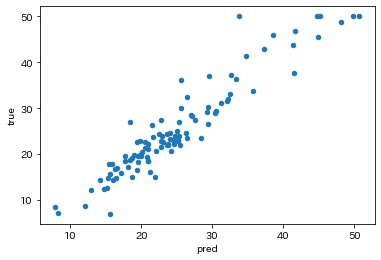

In [123]:
pd.DataFrame({
    "pred": svr_opt.predict(X_test),
    "true": y_test,
}).plot.scatter("pred", "true")

In [52]:
rfr = RandomForestRegressor()

In [53]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [54]:
rfr.feature_importances_

array([0.03345978, 0.00052275, 0.00500824, 0.00118949, 0.02178318,
       0.35730612, 0.01243488, 0.06231122, 0.00508474, 0.0122527 ,
       0.01137513, 0.01542766, 0.46184412])

In [55]:
r2_score(y_pred=rfr.predict(X_train), y_true=y_train)

0.9792091122687117

In [56]:
r2_score(y_pred=rfr.predict(X_test), y_true=y_test)

0.8567816927561908

In [70]:
reg = RandomForestRegressor()

In [71]:
cross_val_score(reg, X=X_test, y=y_test, scoring="r2", cv=5)

array([0.75192882, 0.83142657, 0.71077727, 0.6926323 , 0.04426712])

In [73]:
cross_val_predict(estimator=reg, X=X_test, y=y_test, cv=5, n_jobs=-1) -y_test

array([-2.7060e+00, -5.9900e-01,  5.8850e+00, -1.2360e+00, -7.2200e-01,
        1.9360e+00, -3.7130e+00,  3.2530e+00,  1.0730e+00,  8.7550e+00,
       -2.3800e-01, -5.1100e-01, -1.2689e+01,  6.0900e-01, -4.4300e-01,
       -7.8910e+00,  6.0550e+00, -7.1060e+00, -9.2200e-01,  3.7530e+00,
       -4.0140e+00, -1.3170e+00,  3.8910e+00, -8.6300e-01, -2.4180e+00,
        2.5430e+00, -1.0240e+01, -1.7300e-01, -3.4680e+00, -7.9020e+00,
       -6.2500e-01, -1.3880e+00,  1.7080e+00, -2.5400e-01, -6.8600e-01,
        1.3900e+00,  3.9720e+00, -6.7140e+00,  3.5860e+00,  2.0510e+00,
       -5.8610e+00, -3.2300e+00,  1.6390e+00,  1.6240e+00,  4.7040e+00,
        2.9250e+00, -3.6610e+00, -5.3630e+00, -2.8600e+00,  2.1350e+00,
       -2.6030e+00,  2.0710e+00, -3.6650e+00, -2.5520e+00,  5.9870e+00,
        2.5730e+00,  7.7300e-01, -5.2080e+00,  4.9120e+00,  1.7251e+01,
       -1.2950e+00, -6.0900e-01, -7.5200e+00, -8.9020e+00, -4.5760e+00,
       -9.9500e-01,  1.2180e+00,  2.5920e+00, -2.8730e+00, -1.10

In [61]:
print(boston.DESCR)


.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [64]:
df_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
df_boston["target"] = boston.target
df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [66]:
spark.createDataFrame(df_boston).write.saveAsTable("sklearn.boston", format="orc", compression="zlib")

In [67]:
spark.table("sklearn.boston").show()

+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|target|
+-------+----+-----+----+-----+-----+-----+------+---+-----+-------+------+-----+------+
|0.04819|80.0| 3.64| 0.0|0.392|6.108| 32.0|9.2203|1.0|315.0|   16.4|392.89| 6.57|  21.9|
|0.03548|80.0| 3.64| 0.0|0.392|5.876| 19.1|9.2203|1.0|315.0|   16.4|395.18| 9.25|  20.9|
|0.01538|90.0| 3.75| 0.0|0.394|7.454| 34.2|6.3361|3.0|244.0|   15.9|386.34| 3.11|  44.0|
|0.61154|20.0| 3.97| 0.0|0.647|8.704| 86.9| 1.801|5.0|264.0|   13.0| 389.7| 5.12|  50.0|
|0.66351|20.0| 3.97| 0.0|0.647|7.333|100.0|1.8946|5.0|264.0|   13.0|383.29| 7.79|  36.0|
|0.65665|20.0| 3.97| 0.0|0.647|6.842|100.0|2.0107|5.0|264.0|   13.0|391.93|  6.9|  30.1|
|0.54011|20.0| 3.97| 0.0|0.647|7.203| 81.8|2.1121|5.0|264.0|   13.0| 392.8| 9.59|  33.8|
|0.53412|20.0| 3.97| 0.0|0.647| 7.52| 89.4|2.1398|5.0|264.0|   13.0|388.37| 7.26|  43.1|
|0.52014|20.0| 3.97| 

In [88]:
xgbr = xgb.XGBRegressor(n_estimators=500, objective="reg:squarederror",)

In [91]:
xgbr.fit(X_train, y_train, early_stopping_rounds=None, )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

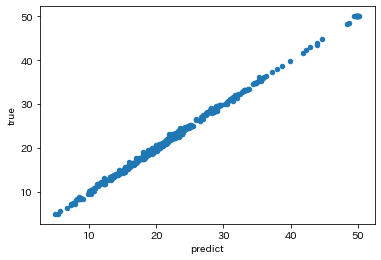

In [93]:
pd.DataFrame({
    "predict": xgbr.predict(X_train),
    "true": y_train,
}).plot.scatter("predict", "true")

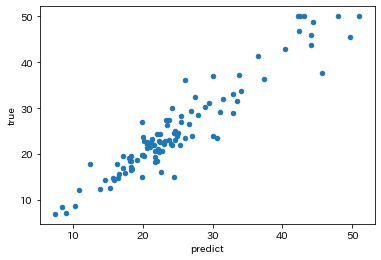

In [94]:
pd.DataFrame({
    "predict": xgbr.predict(X_test),
    "true": y_test,
}).plot.scatter("predict", "true")

In [95]:
r2_score(y_pred=xgbr.predict(X_test), y_true=y_test)

0.893782054660815

In [98]:
xgbr_2 = xgb.XGBRegressor(n_estimators=500, objective="reg:squarederror")
cross_val_score(estimator=xgbr, X=X, y=y, cv=5, n_jobs=-1, scoring="neg_r2")

ValueError: 'neg_r2' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [99]:
lgbr = lgb.LGBMRegressor(n_estimators=500,)

In [100]:
lgbr

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [101]:
cross_val_score(estimator=lgbr, X=X_train, y=y_train, cv=5)

array([0.91024117, 0.87234191, 0.87231724, 0.83507547, 0.71403842])

In [109]:
result = cross_validate(estimator=lgbr, X=X_train, y=y_train, scoring="r2", cv=5, n_jobs=-1, return_estimator=True, return_train_score=True, 
                       fit_params={
                           "early_stopping_rounds": 10,
                           "eval_set": [(X_train, y_train), (X_test, y_test)]
                       })

In [110]:
result

{'fit_time': array([0.2549758 , 0.33827949, 0.15793252, 0.26139712, 0.07632303]),
 'score_time': array([0.00263572, 0.00333929, 0.00188947, 0.00301361, 0.00162482]),
 'estimator': (LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
                random_state=None, reg_alpha

In [115]:
result['test_score'].mean()

0.8388426052165844

In [111]:
xgbr = xgb.XGBRegressor(n_estimators=500)
result2 = cross_validate(estimator=xgbr, X=X_train, y=y_train, scoring="r2", cv=5, n_jobs=-1, return_estimator=True, return_train_score=True, 
                       fit_params={
                           "early_stopping_rounds": 10,
                           "eval_set": [(X_train, y_train), (X_test, y_test)]
                       })
result2

{'fit_time': array([0.20883226, 0.16356516, 0.23707414, 0.22967005, 0.10072732]),
 'score_time': array([0.00169873, 0.00155306, 0.00121999, 0.00166631, 0.00103855]),
 'estimator': (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan, n_estimators=500,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan, n_estimators=500,
               n_jobs=1, nthread=Non

In [116]:
result2["test_score"].mean()

0.8669422186020208

In [117]:
xgbr.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, y_test)])

[17:29:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20.8969	validation_1-rmse:24.4022
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:18.9417	validation_1-rmse:22.2365
[2]	validation_0-rmse:17.1728	validation_1-rmse:20.2414
[3]	validation_0-rmse:15.5863	validation_1-rmse:18.4857
[4]	validation_0-rmse:14.153	validation_1-rmse:16.8711
[5]	validation_0-rmse:12.8559	validation_1-rmse:15.3861
[6]	validation_0-rmse:11.7034	validation_1-rmse:14.119
[7]	validation_0-rmse:10.6545	validation_1-rmse:12.9225
[8]	validation_0-rmse:9.7131	validation_1-rmse:11.8826
[9]	validation_0-rmse:8.86373	validation_1-rmse:10.9221
[10]	validation_0-rmse:8.11264	validation_1-rmse:10.1329
[11]	validation_0-rmse:7.43414	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [118]:
r2_score(y_pred=xgbr.predict(X_test), y_true=y_test)

0.8849650262576161

In [119]:
r2_score(y_pred=xgbr.predict(X_train), y_true=y_train)

0.9769713946318522

In [120]:
lgbr.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_train, y_train), (X_test, y_test)])

[1]	training's l2: 65.0708	valid_1's l2: 100.513
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 55.1651	valid_1's l2: 87.1426
[3]	training's l2: 47.2103	valid_1's l2: 75.8832
[4]	training's l2: 40.5493	valid_1's l2: 67.2276
[5]	training's l2: 35.1255	valid_1's l2: 60.2342
[6]	training's l2: 30.7042	valid_1's l2: 54.4774
[7]	training's l2: 27.0398	valid_1's l2: 49.3105
[8]	training's l2: 24.0467	valid_1's l2: 45.1863
[9]	training's l2: 21.6042	valid_1's l2: 41.9058
[10]	training's l2: 19.5368	valid_1's l2: 38.7828
[11]	training's l2: 17.7418	valid_1's l2: 36.4811
[12]	training's l2: 16.2561	valid_1's l2: 34.5693
[13]	training's l2: 15.0448	valid_1's l2: 32.8834
[14]	training's l2: 13.9077	valid_1's l2: 31.493
[15]	training's l2: 12.9505	valid_1's l2: 30.2817
[16]	training's l2: 12.1334	valid_1's l2: 29.2319
[17]	training's l2: 11.4743	valid_1's l2: 28.4308
[18]	training's l2: 10.7454	valid_1's l2: 27.2031
[19]	training's l2: 10.1257	valid_1's l2: 25.9369

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [121]:
r2_score(y_pred=lgbr.predict(X_train), y_true=y_train)

0.9869289678555995

In [122]:
r2_score(y_pred=lgbr.predict(X_test), y_true=y_test)

0.8641550482150658

In [125]:
optuna.integration.lightgbm.LGBMRegressor()

/opt/conda/lib/python3.7/site-packages/optuna/integration/lightgbm_tuner/sklearn.py:50: UserWarning: LightGBMTuner doesn't support sklearn API. Use `train()` or `LightGBMTuner` for hyperparameter tuning.
  warnings.warn("LightGBMTuner doesn't support sklearn API. "


RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'optuna.integration.lightgbm_tuner.sklearn.LGBMRegressor'> with constructor (self, *args, **kwargs) doesn't  follow this convention.

In [145]:
lgb_optuna = optuna.integration.lightgbm_tuner

In [150]:
best_params, tuning_history = dict(), list()

train_dataset=lgb.Dataset(X_train,y_train)
#valid_dataset=lgb.Dataset(X_test,y_test,reference=train_dataset)
valid_dataset=lgb.Dataset(X_test,y_test)

lgb_optuna.train(
    {"objective":"regression", "metric": "l2"}, 
    X_train, 
    y_train, 
    #train_set=train_dataset, 
    valid_sets=[valid_dataset], 
    #num_boost_rounds=300,
    early_stopping_rounds=20,
    verbose_eval=0, 
    best_params=best_params, 
    tuning_history=tuning_history)









  0%|          | 0/7 [00:00<?, ?it/s]







tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s][W 2020-03-14 18:22:21,574] Setting status of trial#0 as TrialState.FAIL because of the following error: ValueError('The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study.py", line 569, in _run_trial
    result = func(trial)
  File "/opt/conda/lib/python3.7/site-packages/optuna/integration/lightgbm_tuner/optimize.py", line 242, in __call__
    booster = lgb.train(self.lgbm_params, self.train_set, **self.lgbm_kwargs)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py", line 157, in train
    if num_boost_round <= 0:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [143]:
valid_dataset